In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence, partial_dependence
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, roc_curve, roc_auc_score

from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)
from functions import *
from sklearn.model_selection import train_test_split

In [184]:
datetime_cols = ['last_trip_date', 'signup_date']
churn = pd.read_csv('data/churn.csv', parse_dates=datetime_cols)
train_data = pd.read_csv('data/churn_train.csv', parse_dates=datetime_cols)

train_data['num_days_since'] = ((np.max(train_data['last_trip_date'])
                                 -train_data['last_trip_date'])).astype('timedelta64[D]')
train_data['churn'] = (train_data['num_days_since'] > 30)   
train_data['churn'] = train_data['churn'].astype(int) 

ohe = OneHotEncoder()
ohe.fit(train_data['city'])
ohe_city = ohe.transform(train_data['city'])

rating_by_is_nan = train_data['avg_rating_by_driver'].isna().astype(int)
rating_by_is_nan.rename('rating_by_is_nan', inplace=True)
train_data['avg_rating_by_driver'].fillna(
    np.mean(train_data['avg_rating_by_driver']), inplace=True)

rating_of_is_nan = train_data['avg_rating_of_driver'].isna().astype(int)
rating_of_is_nan.rename('rating_of_is_nan', inplace=True)
train_data['avg_rating_of_driver'].fillna(
    np.mean(train_data['avg_rating_by_driver']), inplace=True)

phone_is_iphone = (train_data['phone'] == 'iPhone').astype(int)
phone_is_iphone.rename('is_iphone', inplace=True)
phone_is_android = (train_data['phone'] == 'Android').astype(int)
phone_is_android.rename('is_android', inplace=True)

train_data['luxury_car_user'] = train_data['luxury_car_user'].astype(int)

train_data['miles_per_month'] = train_data['avg_dist'] * train_data['trips_in_first_30_days']

In [185]:
cols_to_use = ['avg_dist',
               'avg_rating_by_driver',
               'avg_rating_of_driver',
               'avg_surge',
               'surge_pct',
               'trips_in_first_30_days',
               'luxury_car_user',
               'weekday_pct',
               'miles_per_month']

In [186]:
frames = [train_data[cols_to_use],
          ohe_city,
          rating_by_is_nan,
          rating_of_is_nan,
          phone_is_android,
          phone_is_iphone]
X = pd.concat(frames, axis=1)
y = train_data['churn']

In [187]:
lr_model = LogisticRegression()
rfc_model = RandomForestClassifier(n_estimators=100,
                                  max_depth=5)
gbc_model = GradientBoostingClassifier(learning_rate=0.01,
                                      n_estimators=1000,
                                      subsample=0.5,
                                      max_depth=5)

In [177]:
kf = KFold(n_splits=10, shuffle=True)
lr_logloss = np.zeros((10,2))
rfc_logloss = np.zeros((10,2))
gbc_logloss = np.zeros((10,2))
for i, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train = X.iloc[train_idx,:]
    X_test = X.iloc[test_idx,:]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    lr_model.fit(X_train, y_train)
    pred_probs_train = lr_model.predict_proba(X_train)
    lr_logloss[i,0] = log_loss(y_train, pred_probs_train)
    pred_probs_test = lr_model.predict_proba(X_test)                           
    lr_logloss[i,1] = log_loss(y_test, pred_probs_test)
    
    rfc_model.fit(X_train, y_train)
    pred_probs_train = rfc_model.predict_proba(X_train)
    rfc_logloss[i,0] = log_loss(y_train, pred_probs_train)
    pred_probs_test = rfc_model.predict_proba(X_test)                           
    rfc_logloss[i,1] = log_loss(y_test, pred_probs_test)
    
    gbc_model.fit(X_train, y_train)
    pred_probs_train = gbc_model.predict_proba(X_train)
    gbc_logloss[i,0] = log_loss(y_train, pred_probs_train)
    pred_probs_test = gbc_model.predict_proba(X_test)                           
    gbc_logloss[i,1] = log_loss(y_test, pred_probs_test)

/Users/heilman/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/heilman/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/heilman/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/heilman/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


KeyboardInterrupt: 

In [139]:
lr_logloss_mean = np.mean(lr_logloss, axis=0)
rfc_logloss_mean = np.mean(rfc_logloss, axis=0)
gbc_logloss_mean = np.mean(gbc_logloss, axis=0)

In [144]:
print('Mean Log Loss (10-fold cross-validation)')
print('Model                     | Train  | Test')
print('--------------------------+--------+-------')
print('LogisticRegression        | {0:6.4f} | {1:6.4f}'.format(lr_logloss_mean[0], lr_logloss_mean[1]))
print('RandomForestClassifier    | {0:6.4f} | {1:6.4f}'.format(rfc_logloss_mean[0], rfc_logloss_mean[1]))
print('GradientBoostingClassifier| {0:6.4f} | {1:6.4f}'.format(gbc_logloss_mean[0], gbc_logloss_mean[1]))

Mean Log Loss (10-fold cross-validation)
Model                     | Train  | Test
--------------------------+--------+-------
LogisticRegression        | 0.5505 | 0.5510
RandomForestClassifier    | 0.4909 | 0.4931
GradientBoostingClassifier| 0.4224 | 0.4510


In [188]:
X_train = X.copy()
y_train = y.copy()

In [189]:
datetime_cols = ['last_trip_date', 'signup_date']
train_data = pd.read_csv('data/churn_test.csv', parse_dates=datetime_cols)
train_data['num_days_since'] = ((np.max(train_data['last_trip_date'])
                                 -train_data['last_trip_date'])).astype('timedelta64[D]')
train_data['churn'] = (train_data['num_days_since'] > 30)   
train_data['churn'] = train_data['churn'].astype(int) 

ohe = OneHotEncoder()
ohe.fit(train_data['city'])
ohe_city = ohe.transform(train_data['city'])

rating_by_is_nan = train_data['avg_rating_by_driver'].isna().astype(int)
rating_by_is_nan.rename('rating_by_is_nan', inplace=True)
train_data['avg_rating_by_driver'].fillna(
    np.mean(train_data['avg_rating_by_driver']), inplace=True)

rating_of_is_nan = train_data['avg_rating_of_driver'].isna().astype(int)
rating_of_is_nan.rename('rating_of_is_nan', inplace=True)
train_data['avg_rating_of_driver'].fillna(
    np.mean(train_data['avg_rating_by_driver']), inplace=True)

phone_is_iphone = (train_data['phone'] == 'iPhone').astype(int)
phone_is_iphone.rename('is_iphone', inplace=True)
phone_is_android = (train_data['phone'] == 'Android').astype(int)
phone_is_android.rename('is_android', inplace=True)

train_data['luxury_car_user'] = train_data['luxury_car_user'].astype(int)

train_data['miles_per_month'] = train_data['avg_dist'] * train_data['trips_in_first_30_days']

In [190]:
frames = [train_data[cols_to_use],
          ohe_city,
          rating_by_is_nan,
          rating_of_is_nan,
          phone_is_android,
          phone_is_iphone]
X = pd.concat(frames, axis=1)
y = train_data['churn']

In [191]:
X_test = X.copy()
y_test = y.copy()

In [192]:
gbc_model.fit(X_train, y_train)
train_preds = gbc_model.predict(X_train)
train_probs = gbc_model.predict_proba(X_train)
test_preds = gbc_model.predict(X_test)
test_probs = gbc_model.predict_proba(X_test)

In [193]:
train_acc = np.mean(train_preds == y_train)
test_acc = np.mean(test_preds == y_test)

In [194]:
train_acc

0.806925

In [195]:
test_acc

0.7701

In [281]:
test_probs[:,0]>0.1

array([False,  True, False, ...,  True, False,  True])

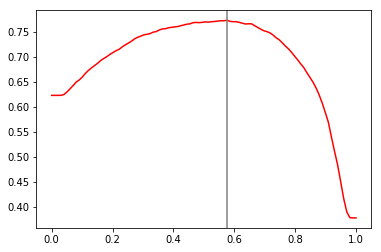

In [284]:
thresh = np.linspace(0,1,100)
acc = np.zeros(100)
for i, t in enumerate(thresh):
    preds = (test_probs[:,1] > t).astype(int)
    acc[i] = np.mean(preds==y_test)

best_idx = np.argmax(acc)    
fig, ax = plt.subplots()
ax.plot(thresh, acc, color='r')
ax.axvline(thresh[best_idx], color='gray');

In [208]:
roc = roc_curve(y_test, test_probs[:,1])

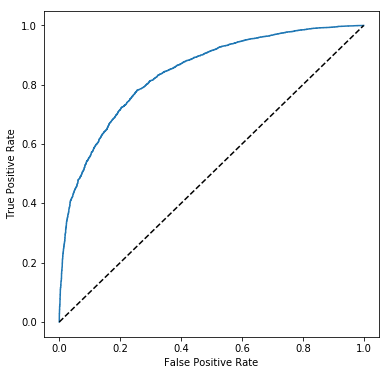

In [214]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(roc[0],roc[1])
ax.plot([0,1],[0,1], linestyle='--', color='black')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.savefig('roc_curve.png')

In [211]:
roc_auc_score(y_test, test_probs[:,1])

0.8409721839113339

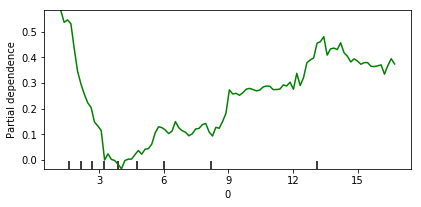

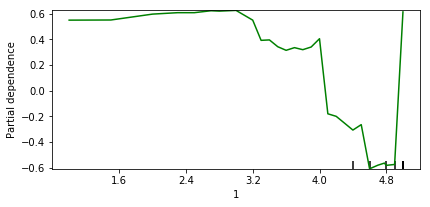

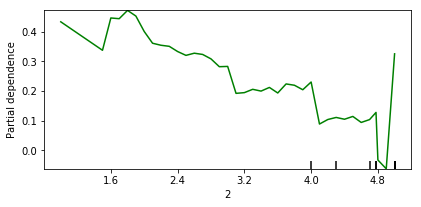

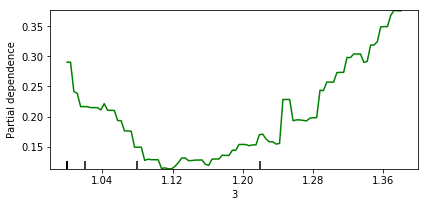

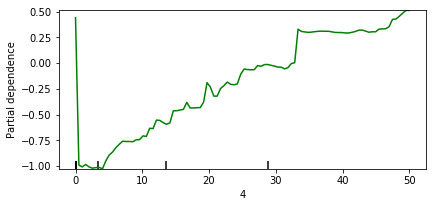

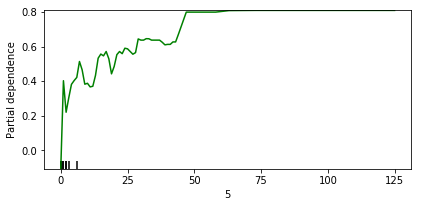

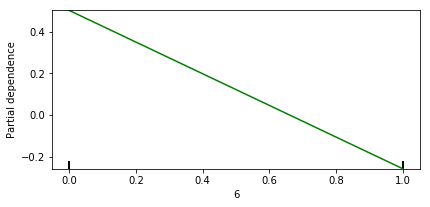

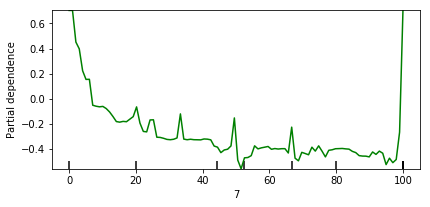

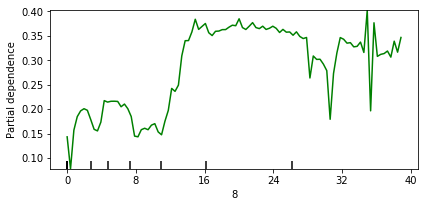

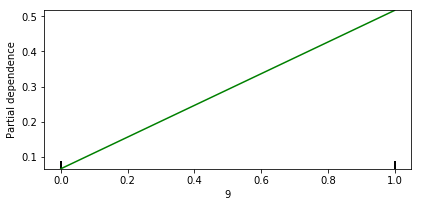

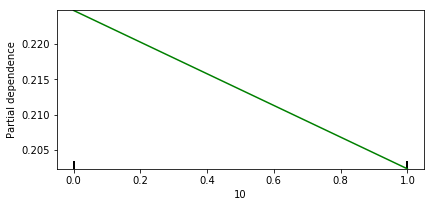

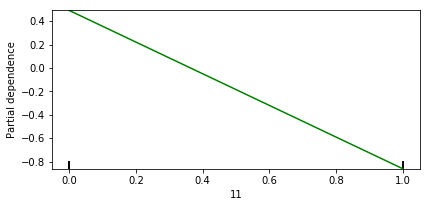

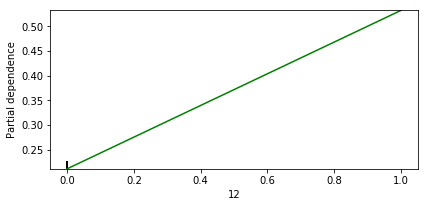

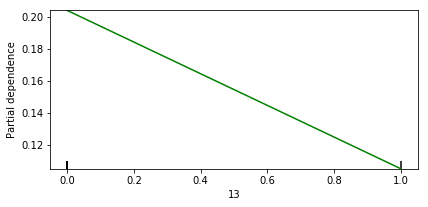

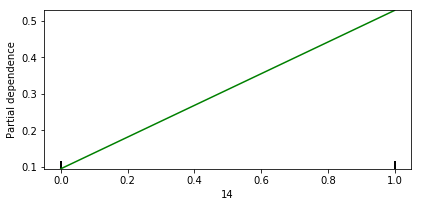

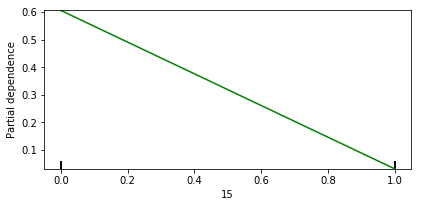

In [230]:
features = X_train.columns
for i, feat in enumerate(features):
    fig, axs = plot_partial_dependence(gbc_model, X_train,[i], label=feat)

In [232]:
feat_imps = gbc_model.feature_importances_

In [258]:
feat_order = list(np.argsort(feat_imps))
ordered_names = []
ordered_feat_imps = []
for i in feat_order:
    ordered_feat_imps.append(feat_imps[i])
    ordered_names.append(features[i])

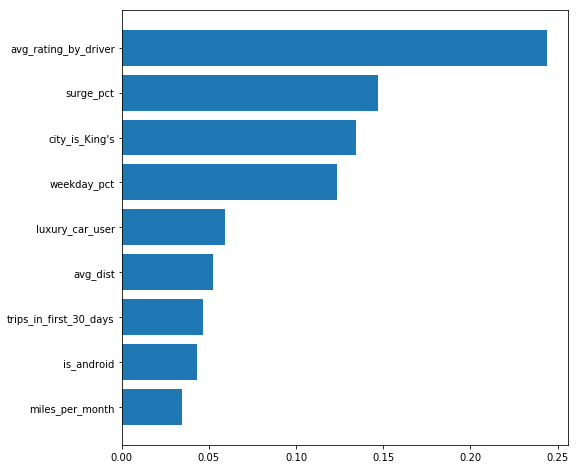

In [250]:
fig, ax = plt.subplots(figsize=(8,8))
ax.barh(y=range(len(features[7:])), width=ordered_feat_imps[7:],  tick_label=ordered_names[7:])
plt.savefig('feature_importances.png')

In [259]:
feat_order.reverse()
ordered_names.reverse()
ordered_feat_imps.reverse()

In [261]:
part_deps = []
for i in range(5):
    part_deps.append(partial_dependence(gbc_model, feat_order[i], X = X_train))

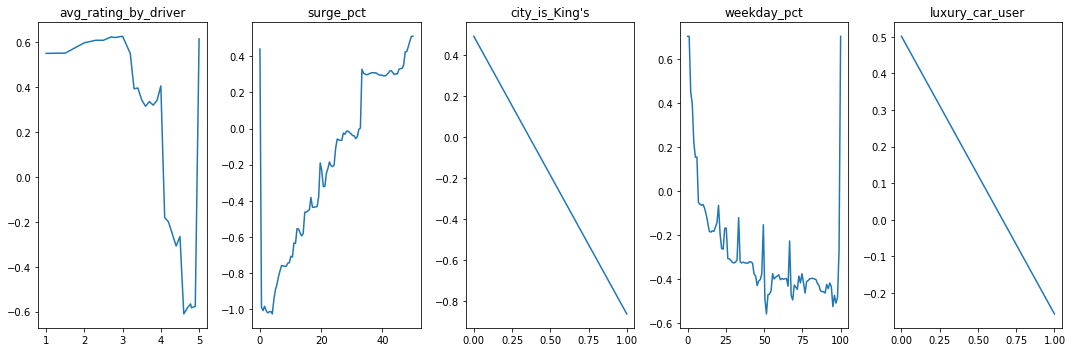

In [274]:
fig, axs = plt.subplots(1,5, figsize=(15,5))
for i, ax in enumerate(axs.flatten()):
    ax.plot(part_deps[i][1][0], part_deps[i][0][0])
    ax.set_title(ordered_names[i])
fig.tight_layout()
plt.savefig('partial_dependencies.png')